In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

In [100]:
def plot_data(data):
    x_label = data.columns[0]
    y_label = data.columns[1]
    plt.plot(data[x_label], data[y_label])
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [101]:
def get_largo(data):
    data_r = data["r"]
    return data_r.mean()

In [102]:
def format_pd(data, feature):
    data = data.dropna()
    # Arranca en t = 0
    print(data["t"].iloc[0])
    data["t"] = data["t"] - data["t"].iloc[0]
    # Selecciona la columna de interés
    try:
        data = data[["t", feature]]
    except KeyError:
        data = data[["t", "θ"]]
    return data

In [103]:
def get_tita0(data):
    try:
        return data["θr"].iloc[0]
    except KeyError:
        return data["θ"].iloc[0]

def get_amplitud(data):  # asumo amplitud como Asen(θ)
    try:
        return (max(data["θr"]) - min(data["θr"])) / 2
    except KeyError:
        return (max(data["θ"]) - min(data["θ"])) / 2

def get_periodo(data):
    try:
        # Localizo un máximo y un mínimo
        maximo = data["θ"].idxmax()
        minimo = data["θ"].idxmin()
        # Calculo el periodo
        return abs((data["t"].iloc[maximo] - data["t"].iloc[minimo])) * 2 # *2 porque es de pico a pico
    except KeyError:
        # Localizo un máximo y un mínimo
        maximo = data["θr"].idxmax()
        minimo = data["θr"].idxmin()
        # Calculo el periodo
        return abs((data["t"].iloc[maximo] - data["t"].iloc[minimo])) * 2 # *2 porque es de pico a pico

def get_frecuencia(data):
    return 1 / get_periodo(data) # NO está en rad/sec, está en Hz

In [104]:
def plot_approximation(data, tita0, amplitud, frecuencia, periodo):
    x = data["t"]
    print(x[0])
    delta = np.arcsin(tita0 / amplitud)
    y = amplitud * np.sin(2 * np.pi * (-frecuencia) * x + delta)
    print(y[0])
    plt.plot(x, y)

0: oro l1\oro35.csv
0.834
θ0: 5.013, A: 6.848, T: 1.2679999999999996, f: 0.7886435331230287
0.0
5.013


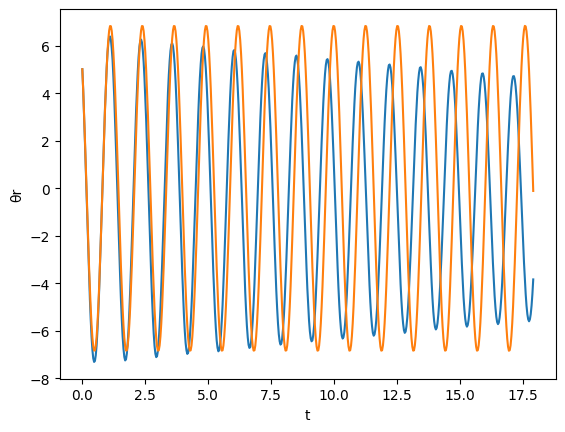

1: oro l1\oro40.csv
2.436
θ0: 12.11, A: 13.379999999999999, T: 1.202, f: 0.831946755407654
0.0
12.11


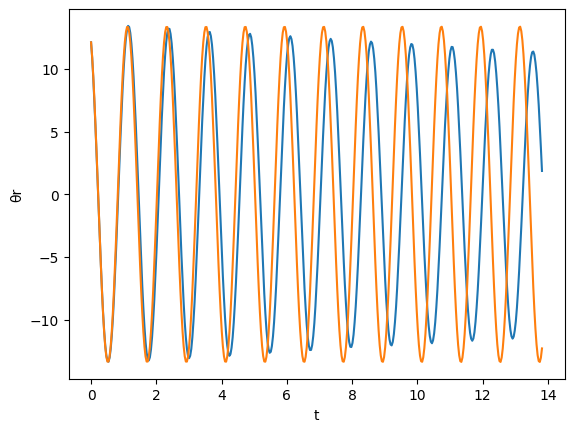

2: oro l1\oro45.csv
1.101
θ0: 19.09, A: 20.5, T: 1.2000000000000002, f: 0.8333333333333333
0.0
19.09


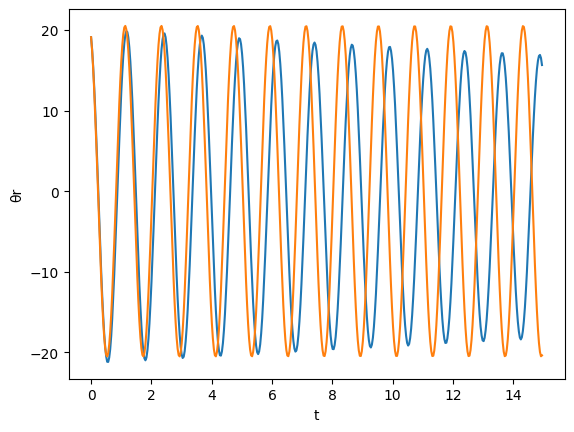

3: oro l1\oro50.csv
1.635
θ0: 26.2, A: 26.91, T: 1.2680000000000007, f: 0.7886435331230279
0.0
26.2


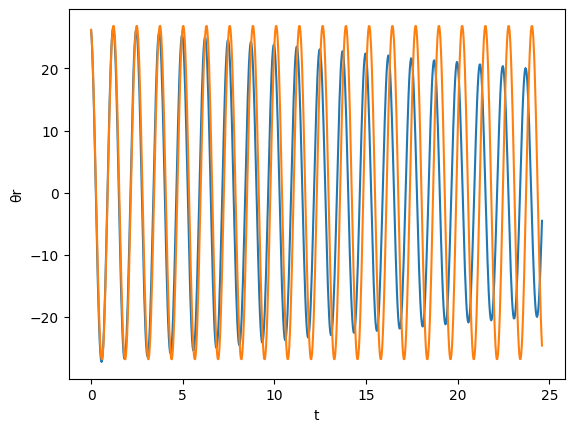

4: plata l0\plata35.csv
1.101
θ0: 2.895, A: 4.034, T: 1.4019999999999992, f: 0.7132667617689019
0.0
2.895


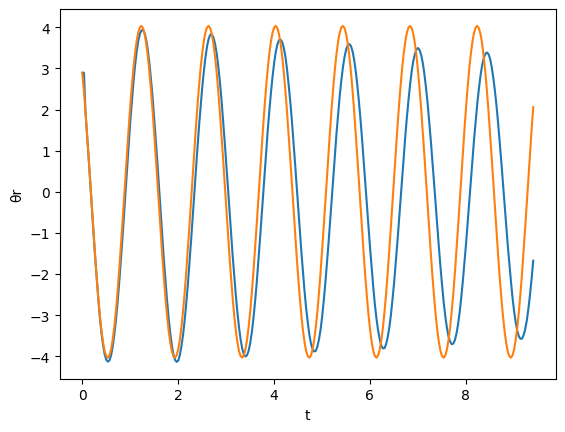

5: plata l0\plata40.csv
1.869
θ0: 8.439, A: 9.8635, T: 1.468, f: 0.6811989100817439
0.0
8.439


C:\Users\xxx\AppData\Local\Temp\ipykernel_20376\3295301198.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["t"] = data["t"] - data["t"].iloc[0]


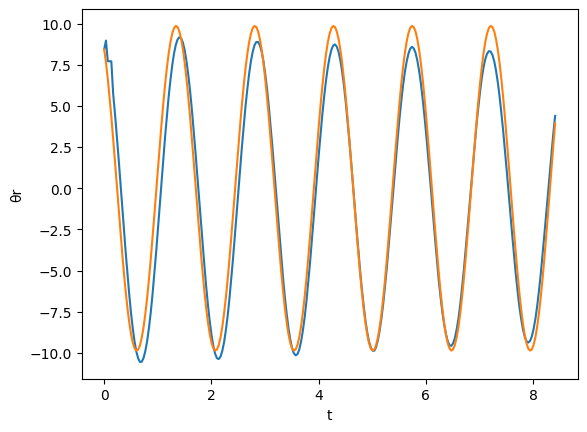

6: plata l0\plata50.csv
1.735
θ0: 15.6, A: 20.744999999999997, T: 1.468, f: 0.6811989100817439
0.0
15.6


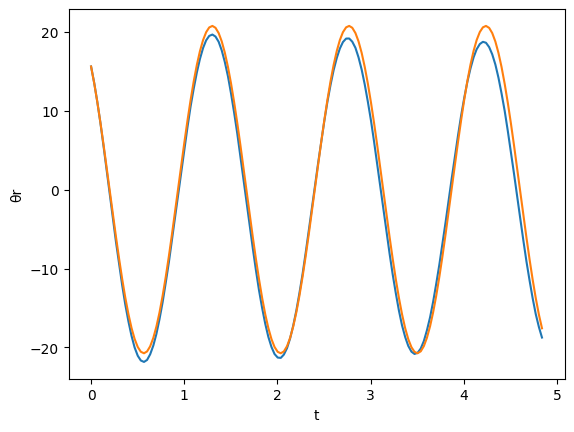

7: plata l0\plata60.csv
1.335


C:\Users\xxx\AppData\Local\Temp\ipykernel_20376\3295301198.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["t"] = data["t"] - data["t"].iloc[0]


θ0: 30.62, A: 32.755, T: 1.4019999999999997, f: 0.7132667617689017
0.0
30.62


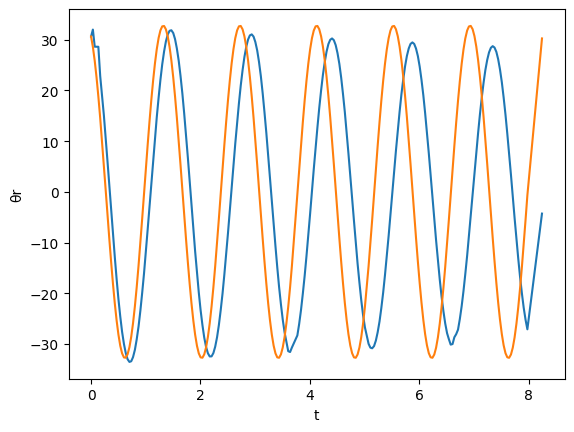

8: plata l1\plata35.csv
1.034
θ0: 8.562, A: 9.7125, T: 1.2680000000000002, f: 0.7886435331230283
0.0
8.562


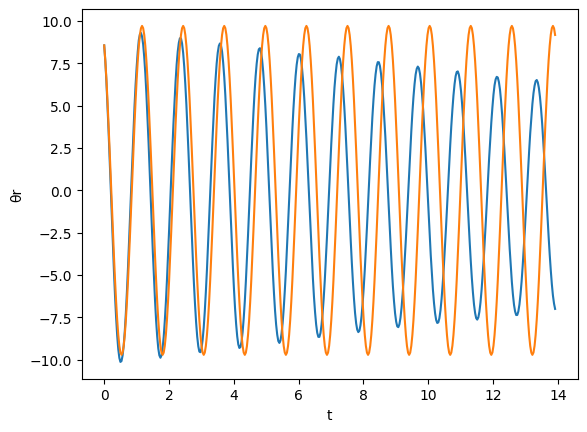

9: plata l1\plata40.csv
1.769
θ0: 13.96, A: 15.04, T: 1.2000000000000002, f: 0.8333333333333333
0.0
13.96


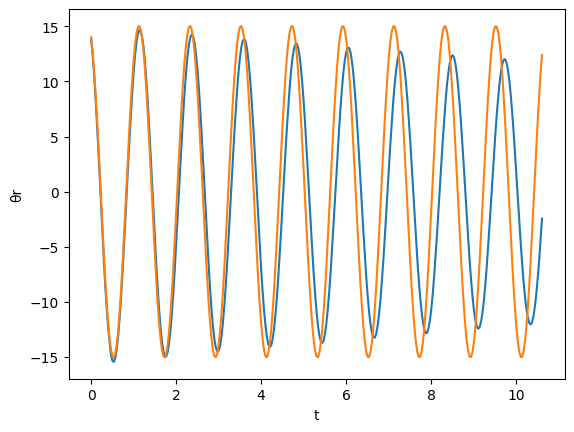

10: plata l1\plata45.csv
1.268
θ0: 21.92, A: 22.495, T: 1.202, f: 0.831946755407654
0.0
21.92


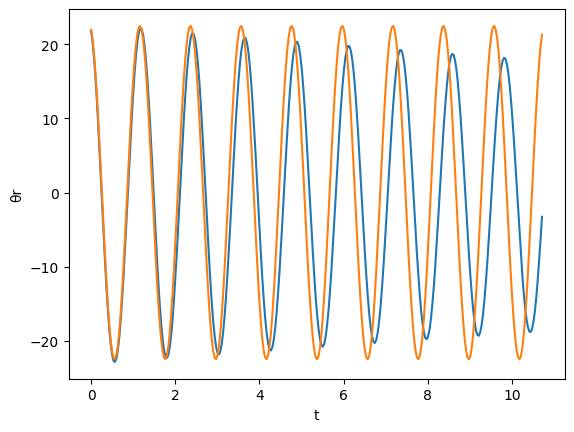

11: plata l1\plata50.csv
1.669
θ0: 30.63, A: 31.04, T: 1.2000000000000002, f: 0.8333333333333333
0.0
30.63


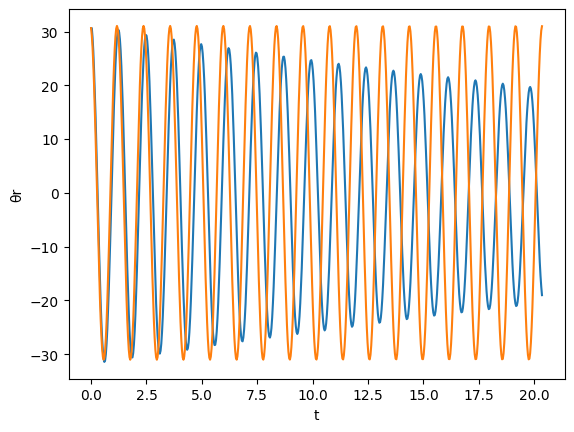

12: plata l2\plata35.csv
1.601667
θ0: 6.907937, A: 7.6523845, T: 1.1366680000000002, f: 0.8797643639127695
0.0
6.907937


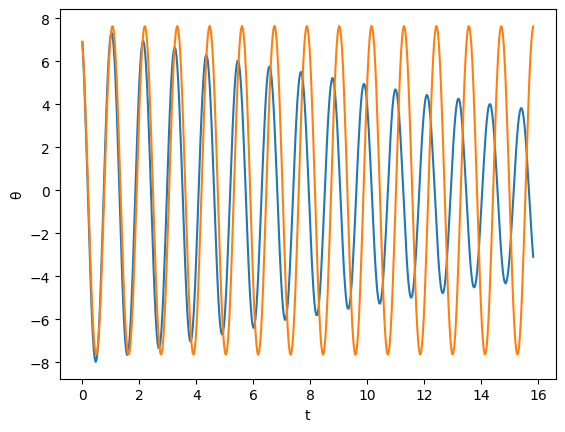

13: plata l2\plata40.csv
2.069
θ0: 16.52, A: 18.805, T: 1.1340000000000003, f: 0.8818342151675482
0.0
16.52


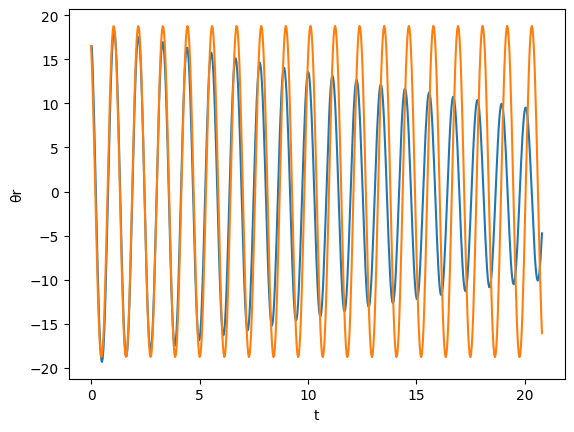

14: plata l2\plata45.csv
0.768
θ0: 24.01, A: 24.16, T: 1.0, f: 1.0
0.0
24.01


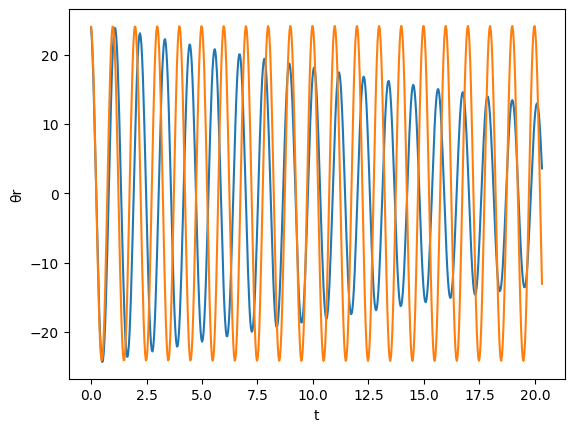

15: plata l2\plata50.csv
1.669
θ0: -107.4, A: 25.599999999999994, T: 1.1340000000000003, f: 0.8818342151675482
0.0
nan


C:\Users\xxx\AppData\Local\Temp\ipykernel_20376\527680681.py:4: RuntimeWarning: invalid value encountered in arcsin
  delta = np.arcsin(tita0 / amplitud)


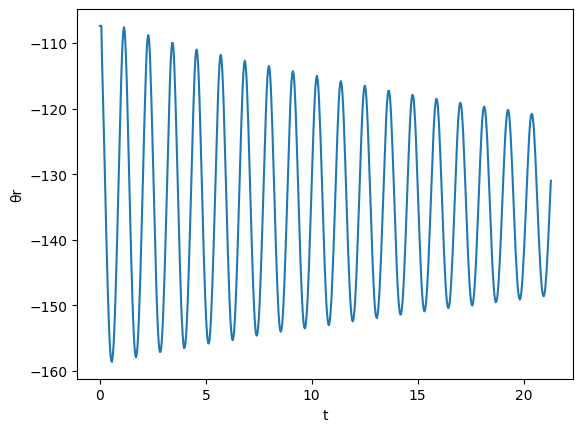

16: plata l3\plata35.csv
0.934
θ0: 8.556, A: 10.2625, T: 0.8679999999999999, f: 1.1520737327188941
0.0
8.556


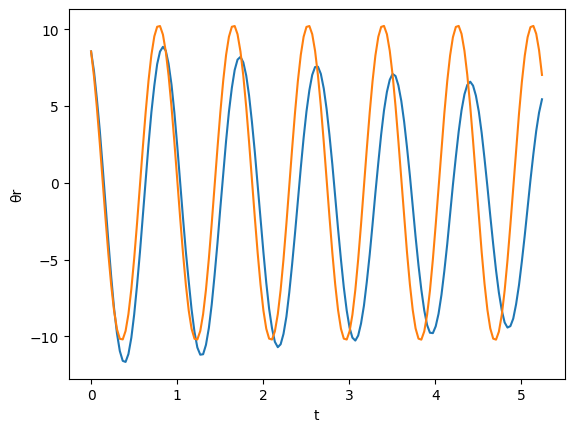

17: plata l3\plata40.csv
0.534
θ0: 23.51, A: 23.355, T: 0.9359999999999997, f: 1.0683760683760688
0.0
nan


C:\Users\xxx\AppData\Local\Temp\ipykernel_20376\527680681.py:4: RuntimeWarning: invalid value encountered in arcsin
  delta = np.arcsin(tita0 / amplitud)


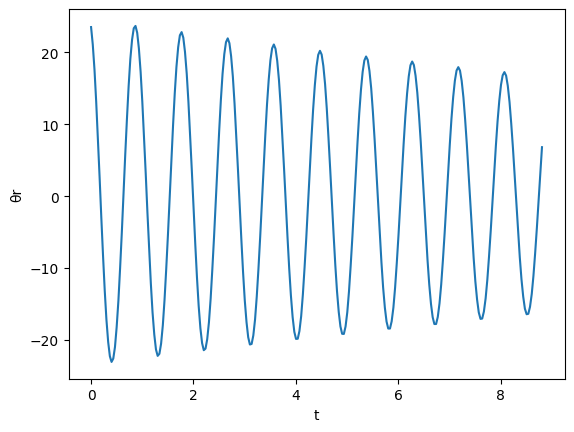

18: plata l3\plata45.csv
1.335
θ0: 30.63, A: 31.125, T: 0.9359999999999995, f: 1.068376068376069
0.0
30.63


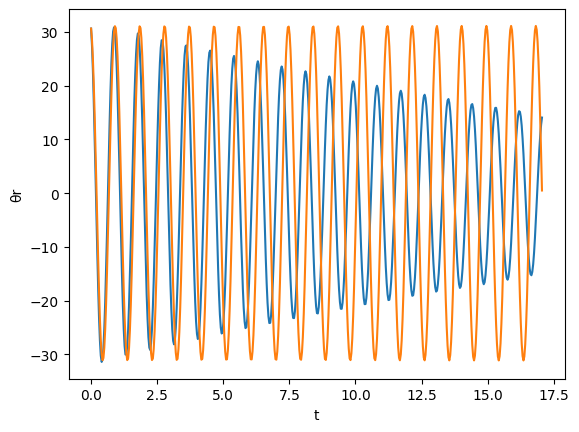

19: plata l3\plata50.csv
2.203
θ0: 44.29, A: 46.91, T: 0.9359999999999999, f: 1.0683760683760684
0.0
44.29


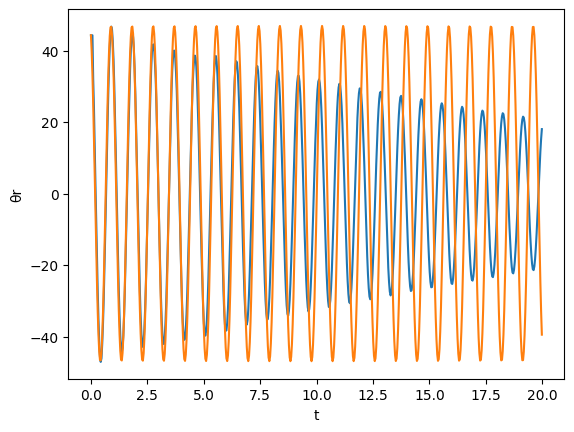

In [105]:
import os
import pandas as pd

# Adjust the input directory path to go up one level from the current directory
input_dir = os.path.join('..', 'datasets')

datasets = []

for folder in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith('.csv'):
                # Add dataset to the list with subfolder and folder
                datasets.append(os.path.join(folder, file))

dataset_params = []

for i, dataset in enumerate(datasets):
    print(f"{i}: {dataset}")
    # Load a specific dataset into a DataFrame
    DATASET_CHOSEN = i
    data = pd.read_csv(os.path.join(input_dir, datasets[DATASET_CHOSEN]))
    L = get_largo(data)
    data = format_pd(data, "θr")
    plot_data(data)
    tita0, amplitud, T, frecuencia = get_tita0(data), get_amplitud(data), get_periodo(data), get_frecuencia(data)
    dataset_params.append((L, tita0, amplitud, T, frecuencia, (23 if dataset.split()[0] == "plata" else 72)))
    print(f"θ0: {tita0}, A: {amplitud}, T: {T}, f: {frecuencia}")
    plot_approximation(data, tita0=tita0, amplitud=amplitud, frecuencia=frecuencia, periodo=T)
    plt.show()


In [115]:
def graph_params(dataset_params):
    # Creo un DataFrame con los datos
    df = pd.DataFrame(dataset_params, columns=["L", "tita0", "A", "T", "f", "m"])

    # order the data by L and cut the first row
    df = df.sort_values(by="L")
    print(df.iloc[0])
    df = df.iloc[1:] # LE ESTOY SACANDO UN OUTLIER MAL DETECTADO

    # Fit a linear regression model to estimate gravity
    # Convierte a un array de 2D: reshape(-1, 1)
    reg = LinearRegression().fit(df["L"].values.reshape(-1, 1), (df["T"]**2).values.reshape(-1, 1))

    # Plot T^2 vs L
    plt.figure()
    plt.scatter(df["L"], df["T"]**2, color='blue', label='Data')
    x = np.linspace(df["L"].min(), df["L"].max(), 100)
    plt.plot(x, reg.predict(x.reshape(-1, 1)), color='red', label='Linear Fit')
    plt.xlabel('Length (L)')
    plt.ylabel('Period Squared (T^2)')
    plt.title('T^2 vs L')
    plt.legend()
    plt.show()

    # Estimate gravity (g) from the slope (T^2 = (4 * pi^2 / g) * L)
    slope = reg.coef_[0][0]
    g_estimated = (4 * np.pi**2 / slope) / 100 # cm to m
    print(f"Estimated gravity (g): {g_estimated} m/s^2")

    # T vs m
    plt.scatter(df["m"], df["T"])
    plt.xlabel("Masa (m)")
    plt.ylabel("T (s)")
    plt.show()

    # T vs tita0
    plt.scatter(df["tita0"], df["T"])
    plt.xlabel("θ0 (rad)")
    plt.ylabel("T (s)")
    plt.show()


L         3.019138
tita0    24.010000
A        24.160000
T         1.000000
f         1.000000
m        23.000000
Name: 14, dtype: float64


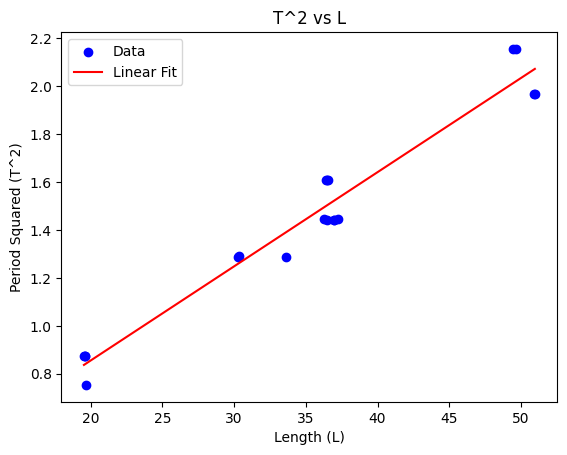

Estimated gravity (g): 10.046419272046334 m/s^2


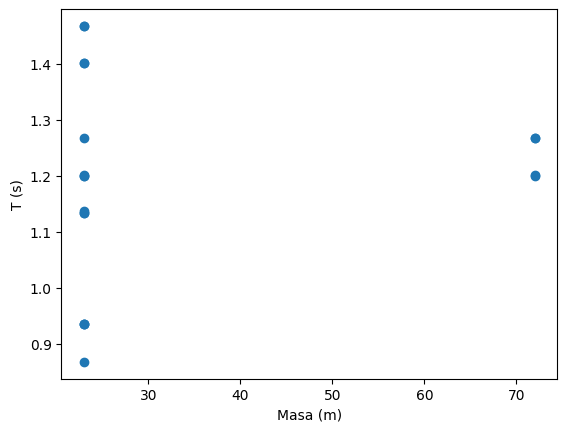

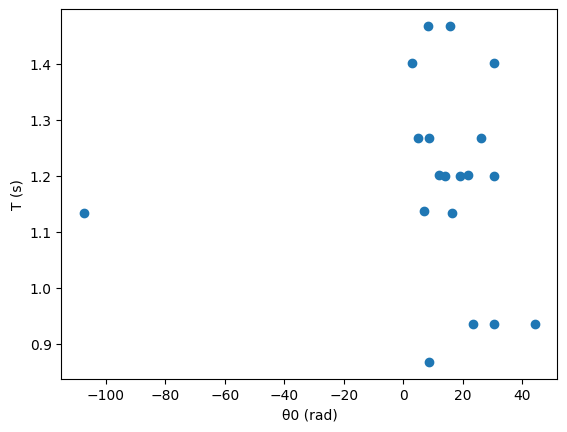

In [116]:
graph_params(dataset_params)
#parecen feos, pero el tema es que hay varios puntos en cada punto grande, lo que muestra que tenemos resultados consistentes!
# habría que ver cómo graficarlo mejor.

In [118]:
print()
print()
print()